In [ ]:

import kagglehub
path = kagglehub.dataset_download('samvram/sarfloodsegmentation')

print('Data source import complete.')
print(path)


100%|██████████| 4.94G/4.94G [02:49<00:00, 31.2MB/s]

Extracting files...


Data source import complete.
/root/.cache/kagglehub/datasets/samvram/sarfloodsegmentation/versions/1


In [ ]:
import os
from glob import glob

paths = glob('/root/.cache/kagglehub/datasets/samvram/sarfloodsegmentation/versions/1/train/trainnebraska_20170731t002118/tiles/')

for path in paths:
    try:
        files = os.listdir(path)
        print(f"Contents of {path}: {files}")
    except FileNotFoundError:
        print(f"Directory not found: {path}")
    except Exception as e:
        print(f"Error accessing {path}: {e}")


# <span class="list-group-item list-group-item-action active" style="color:red;background-color:white;font-size:22px">Import Libraries</span> <a id=1.1.1></a> <br>

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import glob

import time
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
from IPython.display import Image
from skimage import io

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint,LearningRateScheduler
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
# from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split
import cv2
from sklearn.preprocessing import StandardScaler, normalize
from IPython.display import display

In [ ]:
! pip install patchify

# <span class="list-group-item list-group-item-action active" style="color:#FF0000;background-color:white;font-size:25px">UNETR Model architecture</span> <a id=5></a>


In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

from math import log2
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model

def mlp(x, cf):
    x = L.Dense(cf["mlp_dim"], activation="gelu")(x)
    x = L.Dropout(cf["dropout_rate"])(x)
    x = L.Dense(cf["hidden_dim"])(x)
    x = L.Dropout(cf["dropout_rate"])(x)
    return x

def transformer_encoder(x, cf):
    skip_1 = x
    x = L.LayerNormalization()(x)
    x = L.MultiHeadAttention(
        num_heads=cf["num_heads"], key_dim=cf["hidden_dim"]
    )(x, x)
    x = L.Add()([x, skip_1])

    skip_2 = x
    x = L.LayerNormalization()(x)
    x = mlp(x, cf)
    x = L.Add()([x, skip_2])

    return x

def conv_block(x, num_filters, kernel_size=3):
    x = L.Conv2D(num_filters, kernel_size=kernel_size, padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.ReLU()(x)
    return x

def deconv_block(x, num_filters, strides=2):
    x = L.Conv2DTranspose(num_filters, kernel_size=2, padding="same", strides=strides)(x)
    return x

def build_unetr_2d(cf):
    """ Inputs """
    input_shape = (cf["num_patches"], cf["patch_size"]*cf["patch_size"]*cf["num_channels"])
    inputs = L.Input(input_shape) ## (None, 256, 3072)

    """ Patch + Position Embeddings """
    patch_embed = L.Dense(cf["hidden_dim"])(inputs) ## (None, 256, 768)

    positions = tf.range(start=0, limit=cf["num_patches"], delta=1) ## (256,)
    pos_embed = L.Embedding(input_dim=cf["num_patches"], output_dim=cf["hidden_dim"])(positions) ## (256, 768)
    x = patch_embed + pos_embed ## (None, 256, 768)

    """ Transformer Encoder """
    skip_connection_index = [3, 6, 9, 12]
    skip_connections = []

    for i in range(1, cf["num_layers"]+1, 1):
        x = transformer_encoder(x, cf)

        if i in skip_connection_index:
            skip_connections.append(x)

    """ CNN Decoder """
    z3, z6, z9, z12 = skip_connections

    ## Reshaping
    z0 = L.Reshape((cf["image_size"], cf["image_size"], cf["num_channels"]))(inputs)

    shape = (
        cf["image_size"]//cf["patch_size"],
        cf["image_size"]//cf["patch_size"],
        cf["hidden_dim"]
    )
    z3 = L.Reshape(shape)(z3)
    z6 = L.Reshape(shape)(z6)
    z9 = L.Reshape(shape)(z9)
    z12 = L.Reshape(shape)(z12)

    ## Additional layers for managing different patch sizes
    total_upscale_factor = int(log2(cf["patch_size"]))
    upscale = total_upscale_factor - 4

    if upscale >= 2: ## Patch size 16 or greater
        z3 = deconv_block(z3, z3.shape[-1], strides=2**upscale)
        z6 = deconv_block(z6, z6.shape[-1], strides=2**upscale)
        z9 = deconv_block(z9, z9.shape[-1], strides=2**upscale)
        z12 = deconv_block(z12, z12.shape[-1], strides=2**upscale)
        # print(z3.shape, z6.shape, z9.shape, z12.shape)

    if upscale < 0: ## Patch size less than 16
        p = 2**abs(upscale)
        z3 = L.MaxPool2D((p, p))(z3)
        z6 = L.MaxPool2D((p, p))(z6)
        z9 = L.MaxPool2D((p, p))(z9)
        z12 = L.MaxPool2D((p, p))(z12)

    ## Decoder 1
    x = deconv_block(z12, 128)

    s = deconv_block(z9, 128)
    s = conv_block(s, 128)

    x = L.Concatenate()([x, s])

    x = conv_block(x, 128)
    x = conv_block(x, 128)

    ## Decoder 2
    x = deconv_block(x, 64)

    s = deconv_block(z6, 64)
    s = conv_block(s, 64)
    s = deconv_block(s, 64)
    s = conv_block(s, 64)

    x = L.Concatenate()([x, s])
    x = conv_block(x, 64)
    x = conv_block(x, 64)

    ## Decoder 3
    x = deconv_block(x, 32)

    s = deconv_block(z3, 32)
    s = conv_block(s, 32)
    s = deconv_block(s, 32)
    s = conv_block(s, 32)
    s = deconv_block(s, 32)
    s = conv_block(s, 32)

    x = L.Concatenate()([x, s])
    x = conv_block(x, 32)
    x = conv_block(x, 32)

    ## Decoder 4
    x = deconv_block(x, 16)

    s = conv_block(z0, 16)
    s = conv_block(s, 16)

    x = L.Concatenate()([x, s])
    x = conv_block(x, 16)
    x = conv_block(x, 16)

    """ Output """
    outputs = L.Conv2D(1, kernel_size=1, padding="same", activation="sigmoid")(x)

    return Model(inputs, outputs, name="UNETR_2D")

if __name__ == "__main__":
    config = {}
    config["image_size"] = 512
    config["num_layers"] = 12
    config["hidden_dim"] = 64
    config["mlp_dim"] = 128
    config["num_heads"] = 6
    config["dropout_rate"] = 0.1
    config["patch_size"] = 1
    config["num_patches"] = (config["image_size"]**2)//(config["patch_size"]**2)
    config["num_channels"] = 3

    model = build_unetr_2d(config)
    model.summary()

Model: "UNETR_2D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 262144, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 262144, 64)     │            256 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 262144, 64)     │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 262144, 64)     │            128 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 262144, 64)     │         99,520 │ layer_normalization[0… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 262144, 64)     │              0 │ multi_head_attention[… │
│                           │                        │                │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 262144, 64)     │            128 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 262144, 128)    │          8,320 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 262144, 128)    │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 262144, 64)     │          8,256 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 262144, 64)     │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 262144, 64)     │              0 │ dropout_2[0][0],       │
│                           │                        │                │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 262144, 64)     │            128 │ add_2[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 262144, 64)     │         99,520 │ layer_normalization_2… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, 262144, 64)     │              0 │ multi_head_attention_… │
│                           │                        │                │ add_2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_3

 Total params: 2,398,193 (9.15 MB)

 Trainable params: 2,396,465 (9.14 MB)

 Non-trainable params: 1,728 (6.75 KB)

# <span class="list-group-item list-group-item-action active" style="color:#FF0000;background-color:white;font-size:25px">Performance Metrics</span> <a id=5.2></a>


In [ ]:
import numpy as np
import tensorflow as tf

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())
def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac
def weighted_dice_loss(y_true, y_pred):
    # Add class weights - adjust these based on your class distribution
    class_weights = tf.constant([1.0, 2.5])  # [background, flood] weights
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    weighted_true = y_true * class_weights[1] + (1 - y_true) * class_weights[0]
    numerator = 2 * tf.reduce_sum(weighted_true * y_pred) + smooth
    denominator = tf.reduce_sum(weighted_true) + tf.reduce_sum(y_pred) + smooth
    return 1.0 - (numerator / denominator)
def tversky_loss(y_true, y_pred, alpha=0.7, beta=0.3):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    true_pos = tf.reduce_sum(y_true * y_pred)
    false_neg = tf.reduce_sum(y_true * (1 - y_pred))
    false_pos = tf.reduce_sum((1 - y_true) * y_pred)
    tversky_index = (true_pos + smooth) / (true_pos + alpha * false_neg + beta * false_pos + smooth)
    return 1 - tversky_index
def focal_dice_loss(y_true, y_pred):
    # Combines focal loss and dice loss
    alpha = 0.25  # Focusing parameter
    gamma = 2.0   # Modulating parameter
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    # Focal Loss component
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
    focal_loss = -alpha * tf.pow(1. - pt_1, gamma) * tf.math.log(pt_1 + tf.keras.backend.epsilon())
    focal_loss = tf.reduce_mean(focal_loss)
    # Dice Loss component
    intersection = tf.reduce_sum(y_true * y_pred)
    dice_score = (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)
    dice_loss = 1 - dice_score
    return focal_loss + dice_loss

# <span class="list-group-item list-group-item-action active" style="color:#FF0000;background-color:white;font-size:25px">Model Train</span> <a id=5.2></a>


Total number of images: 1120
Sample image paths:
VV Image: /root/.cache/kagglehub/datasets/samvram/sarfloodsegmentation/versions/1/train/train/bangladesh_20170314t115609/tiles/vv/bangladesh_20170314t115609_x-36_y-20_vv.png
Mask: /root/.cache/kagglehub/datasets/samvram/sarfloodsegmentation/versions/1/train/train/bangladesh_20170314t115609/tiles/flood_label/bangladesh_20170314t115609_x-36_y-20.png
---
VV Image: /root/.cache/kagglehub/datasets/samvram/sarfloodsegmentation/versions/1/train/train/bangladesh_20170314t115609/tiles/vv/bangladesh_20170314t115609_x-30_y-24_vv.png
Mask: /root/.cache/kagglehub/datasets/samvram/sarfloodsegmentation/versions/1/train/train/bangladesh_20170314t115609/tiles/flood_label/bangladesh_20170314t115609_x-30_y-24.png
---
VV Image: /root/.cache/kagglehub/datasets/samvram/sarfloodsegmentation/versions/1/train/train/bangladesh_20170314t115609/tiles/vv/bangladesh_20170314t115609_x-10_y-9_vv.png
Mask: /root/.cache/kagglehub/datasets/samvram/sarfloodsegmentation/ver

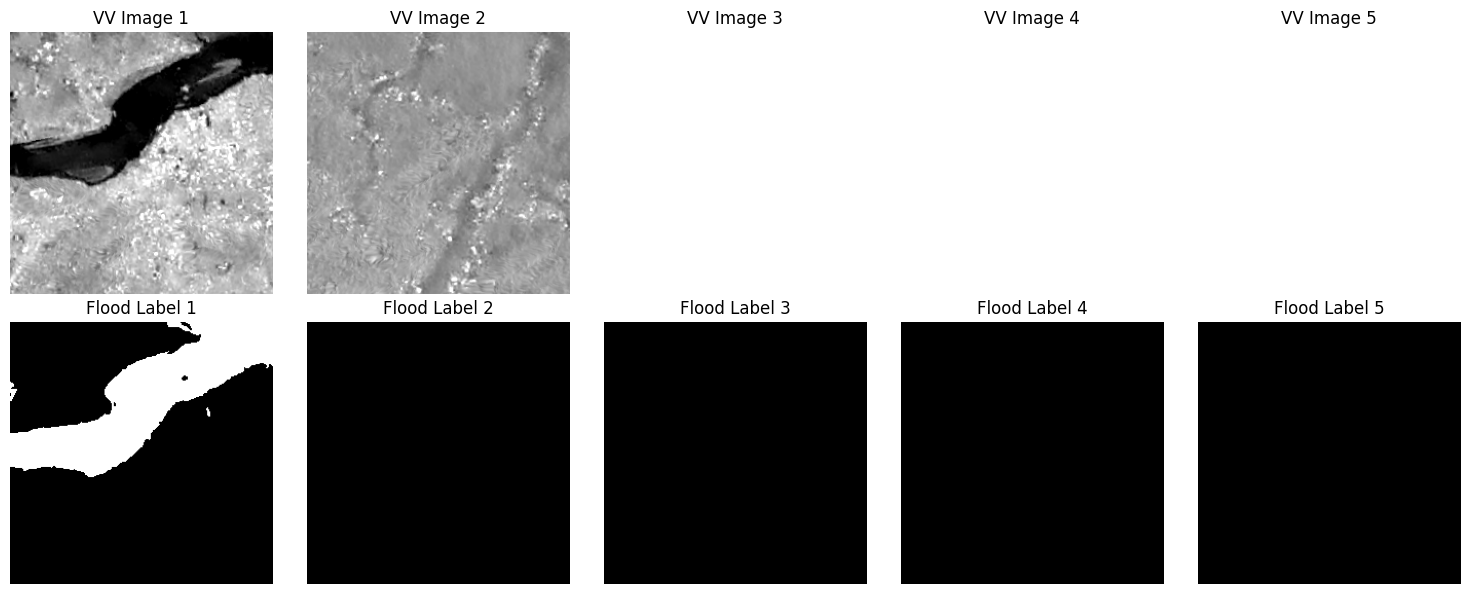

In [ ]:
import os
import numpy as np
import cv2
from glob import glob
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def load_dataset(train_size=1000, test_size=200, valid_size=200, split=0.1):
    """ Loading the images and masks """
    # Get all VV image paths
    X = sorted(glob("/root/.cache/kagglehub/datasets/samvram/sarfloodsegmentation/versions/1/train/train/*/*/vv/*.png"))

    # Create a matching list of mask paths
    Y = []
    for vv_path in X:
        # Extract the filename
        vv_filename = os.path.basename(vv_path)

        # Construct the corresponding mask path
        mask_path = vv_path.replace('/vv/', '/flood_label/').replace('_vv.png', '.png')
        Y.append(mask_path)

    # Truncate to desired dataset size
    X = X[:train_size + test_size + valid_size]
    Y = Y[:train_size + test_size + valid_size]

    if len(X) == 0:
        raise ValueError("Not enough samples to split.")

    # Calculate split size, ensuring it's a valid value
    split_size = int(len(X) * split)
    if split_size == 0:
        split_size = 1  # Avoid zero split size

    # Splitting the data into training and testing
    train_x, valid_x = train_test_split(X, test_size=split_size, random_state=42)
    train_y, valid_y = train_test_split(Y, test_size=split_size, random_state=42)
    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=split_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

def load_and_preprocess_image(image_path, mask_path):
    """
    Load and preprocess both image and mask with error handling
    """
    # Read VV image
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    if img is None:
        print(f"Error: Could not read image {image_path}")
        return None, None

    # Read corresponding mask
    mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
    if mask is None:
        print(f"Error: Could not read mask {mask_path}")
        return None, None

    # Resize images
    try:
        img_resized = cv2.resize(img, (256, 256))
        mask_resized = cv2.resize(mask, (256, 256))
        return img_resized, mask_resized
    except Exception as e:
        print(f"Error resizing images: {e}")
        print(f"Image shape: {img.shape}, Mask shape: {mask.shape}")
        return None, None

def visualize_sample_data(data_x, data_y, num_samples=5):
    """ Visualize sample images and masks with random selection """
    # Randomly select indices
    sample_indices = random.sample(range(len(data_x)), min(num_samples, len(data_x)))

    # Create figure with subplots
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))

    valid_samples = 0
    for i, idx in enumerate(sample_indices):
        # Load and preprocess images
        img, mask = load_and_preprocess_image(data_x[idx], data_y[idx])

        if img is None or mask is None:
            print(f"Skipping sample {idx}")
            continue

        # Plot VV image
        axes[0, valid_samples].imshow(img, cmap='gray')
        axes[0, valid_samples].set_title(f'VV Image {valid_samples+1}')
        axes[0, valid_samples].axis('off')

        # Plot mask
        axes[1, valid_samples].imshow(mask, cmap='gray')
        axes[1, valid_samples].set_title(f'Flood Label {valid_samples+1}')
        axes[1, valid_samples].axis('off')

        valid_samples += 1

        # Break if we've plotted enough valid samples
        if valid_samples >= num_samples:
            break

    plt.tight_layout()
    plt.show()

def main_visualization():
    """ Main function to load and visualize data """
    # Create directories
    create_dir("files")

    # Load dataset
    (train_x, train_y), _, _ = load_dataset()

    # Print out some diagnostic information
    print(f"Total number of images: {len(train_x)}")
    print("Sample image paths:")
    for x, y in zip(train_x[:5], train_y[:5]):
        print(f"VV Image: {x}")
        print(f"Mask: {y}")
        print("---")

    # Visualize sample data
    visualize_sample_data(train_x, train_y)

if __name__ == "__main__":
    main_visualization()

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam, SGD
from sklearn.model_selection import train_test_split
from patchify import patchify
from keras.optimizers.schedules import CosineDecay
from sklearn.model_selection import StratifiedShuffleSplit

""" UNETR Configuration """
cf = {}
cf["image_size"] = 256
cf["num_channels"] = 3
cf["num_layers"] = 12
cf["hidden_dim"] = 128
cf["mlp_dim"] = 32
cf["num_heads"] = 6
cf["dropout_rate"] = 0.1
cf["patch_size"] = 16
cf["num_patches"] = (cf["image_size"]**2)//(cf["patch_size"]**2)
cf["flat_patches_shape"] = (
    cf["num_patches"],
    cf["patch_size"]*cf["patch_size"]*cf["num_channels"]
)

def read_image(path):
    path = path.decode()
    image = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    image = cv2.resize(image, (cf["image_size"], cf["image_size"]))
    image = image / 255.0

    """ Processing to patches """
    patch_shape = (cf["patch_size"], cf["patch_size"], cf["num_channels"])
    patches = patchify(image, patch_shape, cf["patch_size"])
    patches = np.reshape(patches, cf["flat_patches_shape"])
    patches = patches.astype(np.float32)

    return patches

def read_mask(path):
    path = path.decode()
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (cf["image_size"], cf["image_size"]))
    mask = mask / 255.0
    mask = mask.astype(np.float32)
    mask = np.expand_dims(mask, axis=-1)
    return mask

def augment_data(image, mask):
    # Random flip
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)
    return image, mask

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape(cf["flat_patches_shape"])
    y.set_shape([cf["image_size"], cf["image_size"], 1])
    return x, y

def tf_dataset(X, Y, batch=2, is_training=False):
    ds = tf.data.Dataset.from_tensor_slices((X, Y))
    ds = ds.map(tf_parse)
    if is_training:
        ds = ds.map(augment_data)
        ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch).prefetch(tf.data.AUTOTUNE)
    return ds

if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory for storing files """
    create_dir("files")

    """ Hyperparameters """
    batch_size = 8
    lr = 0.1
    num_epochs = 100
    model_path = os.path.join("files", "model.keras")
    csv_path = os.path.join("files", "log.csv")

    """ Dataset """
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset()

    print(f"Train: \t{len(train_x)} - {len(train_y)}")
    print(f"Valid: \t{len(valid_x)} - {len(valid_y)}")
    print(f"Test: \t{len(test_x)} - {len(test_y)}")

    train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
    valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

    initial_lr = 1e-4  # Starting learning rate
    decay_steps = num_epochs * len(train_dataset)  # Total training steps
    lr_schedule = CosineDecay(
        initial_learning_rate=initial_lr,
        decay_steps=decay_steps,
        alpha=0.0  # Minimum learning rate factor
    )

    optimizer = Adam(learning_rate=lr_schedule)

    """ Model """
    model = build_unetr_2d(cf)
    model.compile(
        loss=tversky_loss,
        optimizer=optimizer,
        metrics=[dice_coef, iou, "acc", sensitivity, precision, specificity]
    )
    # model.summary()

    reduce_lr = ReduceLROnPlateau(
      monitor='val_dice_coef',  # Changed from val_loss
      factor=0.2,
      patience=5,
      min_lr=1e-6,
      verbose=1
  )

    callbacks = [
    ModelCheckpoint(
        model_path,
        monitor='val_loss',  # Changed from val_dice_coef
        mode='min',  # Monitor minimum val_loss
        verbose=1,
        save_best_only=True
    ),
    # ReduceLROnPlateau(
    #     monitor='val_loss',  # Changed from val_dice_coef
    #     factor=0.2,
    #     patience=5,
    #     min_lr=1e-6,
    #     verbose=1
    # ),
    CSVLogger(csv_path),
    EarlyStopping(
        monitor='val_loss',  # Changed from val_dice_coef
        mode='min',  # Monitor minimum val_loss
        patience=15,
        restore_best_weights=True
    )
]

    model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=valid_dataset,
        callbacks=callbacks
    )

Train: 	1120 - 1120
Valid: 	140 - 140
Test: 	140 - 140
Epoch 1/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - acc: 0.3924 - dice_coef: 0.0699 - iou: 0.0381 - loss: 0.8971 - precision: 0.0427 - sensitivity: 0.8304 - specificity: 0.3756
Epoch 1: val_loss improved from inf to 0.94710, saving model to files/model.keras
140/140 ━━━━━━━━━━━━━━━━━━━━ 132s 229ms/step - acc: 0.3934 - dice_coef: 0.0699 - iou: 0.0381 - loss: 0.8971 - precision: 0.0427 - sensitivity: 0.8304 - specificity: 0.3767 - val_acc: 0.9385 - val_dice_coef: 0.0328 - val_iou: 0.0171 - val_loss: 0.9471 - val_precision: 0.1226 - val_sensitivity: 0.4434 - val_specificity: 0.9371
Epoch 2/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - acc: 0.7981 - dice_coef: 0.1112 - iou: 0.0644 - loss: 0.8433 - precision: 0.1298 - sensitivity: 0.8027 - specificity: 0.7957
Epoch 2: val_loss improved from 0.94710 to 0.94477, saving model to files/model.keras
140/140 ━━━━━━━━━━━━━━━━━━━━ 73s 151ms/step - acc: 0.7982 - dice_coef: 0.1111 - iou: 0

# <span class="list-group-item list-group-item-action active" style="color:#FF0000;background-color:white;font-size:25px">Model Test</span> <a id=5.2></a>


In [ ]:
def tversky_loss(y_true, y_pred, alpha=0.7, beta=0.3):
    smooth = 1e-6
    y_true_flat = tf.keras.backend.flatten(y_true)
    y_pred_flat = tf.keras.backend.flatten(y_pred)
    true_pos = tf.reduce_sum(y_true_flat * y_pred_flat)
    false_neg = tf.reduce_sum(y_true_flat * (1 - y_pred_flat))
    false_pos = tf.reduce_sum((1 - y_true_flat) * y_pred_flat)
    tversky = (true_pos + smooth) / (true_pos + alpha * false_neg + beta * false_pos + smooth)
    return 1 - tversky


In [ ]:
from tensorflow.keras.models import load_model

# Load the best model saved during training
model = load_model("files/model.keras", custom_objects={
    'tversky_loss': tversky_loss,
    'dice_coef': dice_coef,
    'iou': iou,
    'sensitivity': sensitivity,
    'precision': precision,
    'specificity': specificity
})


In [ ]:
test_dataset = tf_dataset(test_x, test_y, batch=batch_size)
test_metrics = model.evaluate(test_dataset)
print(f"Test Metrics: {test_metrics}")


18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 173ms/step - acc: 0.9912 - dice_coef: 0.4736 - iou: 0.3654 - loss: 0.5223 - precision: 0.6244 - sensitivity: 0.4872 - specificity: 0.9972
Test Metrics: [0.5617552399635315, 0.42420345544815063, 0.3229259252548218, 0.9862749576568604, 0.4538205862045288, 0.5614367127418518, 0.996077299118042]


In [ ]:
test_results = model.evaluate(test_dataset)

# Unpack the metrics
test_loss = test_results[0]
test_dice_coef = test_results[1]
test_iou = test_results[2]
test_acc = test_results[3]
test_sensitivity = test_results[4]
test_precision = test_results[5]
test_specificity = test_results[6]

# Print metrics
print(f"Test Loss: {test_loss}")
print(f"Test Dice Coefficient: {test_dice_coef}")
print(f"Test IoU: {test_iou}")
print(f"Test Accuracy: {test_acc}")
print(f"Test Sensitivity: {test_sensitivity}")
print(f"Test Precision: {test_precision}")
print(f"Test Specificity: {test_specificity}")


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - acc: 0.9912 - dice_coef: 0.4736 - iou: 0.3654 - loss: 0.5223 - precision: 0.6244 - sensitivity: 0.4872 - specificity: 0.9972
Test Loss: 0.5617552399635315
Test Dice Coefficient: 0.42420345544815063
Test IoU: 0.3229259252548218
Test Accuracy: 0.9862749576568604
Test Sensitivity: 0.4538205862045288
Test Precision: 0.5614367127418518
Test Specificity: 0.996077299118042


In [ ]:
import cv2
import numpy as np
from patchify import patchify
import requests

# Configuration (adjusted to your model's settings)
cf = {
    "image_size": 256,
    "patch_size": 16,
    "num_channels": 3,
    "flat_patches_shape": (
        (256**2) // (16**2),
        16 * 16 * 3,
    )
}

def download_image(image_url, save_path):
    """Download an image from the URL and save it locally."""
    response = requests.get(image_url)
    if response.status_code == 200:
        with open(save_path, "wb") as f:
            f.write(response.content)
        print(f"Image downloaded to: {save_path}")
    else:
        print("Failed to download the image.")
        raise Exception("Image download failed.")

def preprocess_image(image_path):
    """Preprocess the image for UNETR model."""
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (cf["image_size"], cf["image_size"]))
    image = image / 255.0  # Normalize pixel values to [0, 1]

    # Convert to patches
    patch_shape = (cf["patch_size"], cf["patch_size"], cf["num_channels"])
    patches = patchify(image, patch_shape, cf["patch_size"])
    patches = np.reshape(patches, cf["flat_patches_shape"])
    patches = np.expand_dims(patches, axis=0)  # Add batch dimension
    return patches

def predict_image(image_path, model):
    """Make predictions on the preprocessed image."""
    patches = preprocess_image(image_path)

    # Predict using the trained model
    prediction = model.predict(patches)
    prediction = np.squeeze(prediction)  # Remove batch dimension
    prediction = (prediction > 0.5).astype(np.uint8)  # Thresholding
    return prediction

# Main execution
if __name__ == "__main__":
    # Image URL and local path
    # image_url = "https://images.ctfassets.net/nzn0tepgtyr1/4ypj3eCaLviEiUEElZ4nD7/5bf069a6c111ad1523d6daa29c744856/SAR-based_water_detection_can_be_combined_with_the_elevation_data_with_river.png"
    image_path = "/content/florence_20180603t231344_x-10_y-26_vv.png"

    # Download the image
    # download_image(image_url, image_path)

    # Predict using the trained model
    prediction = predict_image(image_path, model)

    # Display result
    if np.max(prediction) > 0:  # If any pixel in the mask is "1"
        print("Flood detected.")
    else:
        print("No flood detected.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Flood detected.


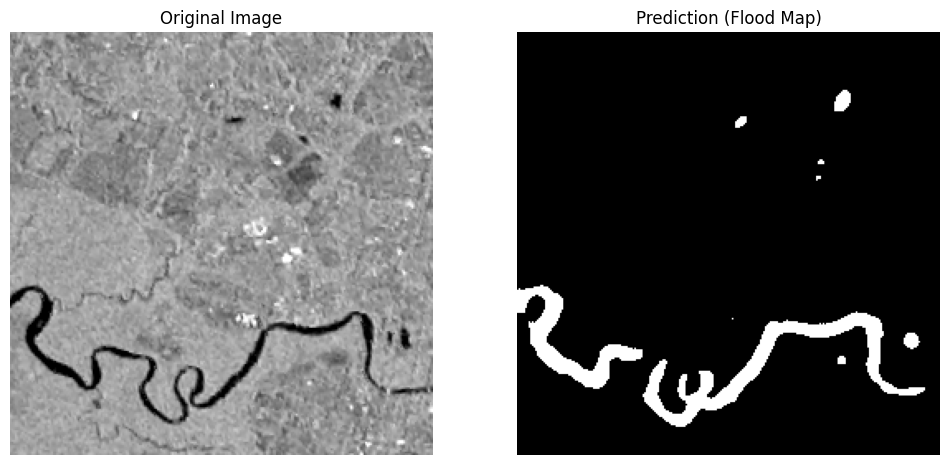

In [ ]:
import matplotlib.pyplot as plt

# Display the original image
original_image = cv2.imread(image_path, cv2.IMREAD_COLOR)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

# Display prediction
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_image)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Prediction (Flood Map)")
plt.imshow(prediction, cmap="gray")
plt.axis("off")

plt.show()


In [ ]:
from google.colab import files
files.download('files/model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>